# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [120]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer
import copy

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import optuna

In [105]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

## Dataset

We load the dataset and split the training set in a stratified train/validation set.

In [66]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

In [67]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

## Vocabulary

In [68]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")

unknown_token = "<unk>"
pad_token = "<pad>"
vocabulary = vocab(
    Counter([token for text in train_df["text"] for token in tokenizer(text)]),
    min_freq=5,
    specials=[unknown_token, pad_token],
)

## Vectorize and batch the input

In [69]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor([vocabulary[token] if token in vocabulary else vocabulary["<unk>"] for token in tokenizer(text)], dtype=torch.long)

In [70]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

## Splitting Dataset

In [71]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [72]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y, random_state=SEED)
    for i in range(0, len(X), batch_size):
        X_batch, y_batch = X[i : i + batch_size], y[i : i + batch_size]

        for batch_idx in range(len(X_batch)):
            padding_size = (max([len(x) for x in X_batch]) - len(X_batch[batch_idx]), 0)
            X_batch[batch_idx] = nn.functional.pad(X_batch[batch_idx], padding_size, value=pad_id)

        yield torch.stack(X_batch), torch.tensor(y_batch, dtype=torch.float32)

In [73]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [74]:
for x in train_gen():
    print(x[0][0])
    break

tensor([    1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [75]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [76]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [77]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    train_losses = []
    valid_losses = []
    best_model = None
    best_valid_loss = np.inf

    for epoch in tqdm(range(n_epochs)):
        model.train()
        for X_batch, y_batch in train_gen():
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        train_losses.append(np.mean(loss.item()))

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in valid_gen():
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)

            valid_losses.append(np.mean(loss.item()))

            if np.mean(loss.item()) < best_valid_loss:
                best_valid_loss = np.mean(loss.item())
                best_model = copy.deepcopy(model)

        print(f"Epoch {epoch+1}/{n_epochs} | Training loss: {train_losses[-1]} | Validation loss: {valid_losses[-1]}")

    return best_model, train_losses, valid_losses

In [78]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [79]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 10, train_gen, valid_gen)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Training loss: 0.6378503441810608 | Validation loss: 0.5418699979782104
Epoch 2/10 | Training loss: 0.6271184682846069 | Validation loss: 0.6388941407203674
Epoch 3/10 | Training loss: 0.6569769382476807 | Validation loss: 0.6553595066070557
Epoch 4/10 | Training loss: 0.6218198537826538 | Validation loss: 0.4943481683731079
Epoch 5/10 | Training loss: 0.6542733907699585 | Validation loss: 0.5386433601379395
Epoch 6/10 | Training loss: 0.5474112033843994 | Validation loss: 0.6326884031295776
Epoch 7/10 | Training loss: 0.6268628835678101 | Validation loss: 0.5865952968597412
Epoch 8/10 | Training loss: 0.6635971665382385 | Validation loss: 0.688930869102478
Epoch 9/10 | Training loss: 0.6170727014541626 | Validation loss: 0.5967481732368469
Epoch 10/10 | Training loss: 0.5544254779815674 | Validation loss: 0.4682680666446686


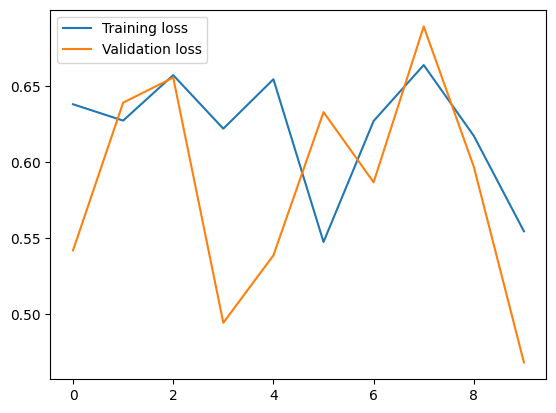

In [80]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)

**\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.

In [81]:
def accuracy(model: nn.Module, gen: Callable) -> float:
    """
    Compute the accuracy of a model on a given dataset.
    :param model: Model to evaluate.
    :param gen: generator function returning a batch (X, y).
    :return: the accuracy of the model on the given dataset.
    """
    model.eval()
    correct_sample = 0
    tot_sample = 0
    for X_batch, y_batch in gen():
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        
        # Sigmoid for binary classification.
        y_pred = torch.sigmoid(y_pred.squeeze())
        y_pred = torch.round(y_pred)

        correct_sample += (y_pred == y_batch).sum().item()
        tot_sample += y_batch.size(0)

    return correct_sample / tot_sample

In [82]:
print(f"Accuracy : Train {accuracy(model, train_gen)} Valid {accuracy(model, valid_gen)} Test {accuracy(model, test_gen)}")

Accuracy : Train 0.8329 Valid 0.7504 Test 0.75192


* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [100]:
class LSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs
        
        # The word embedding layer.
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # The LSTM
        self.lstm = nn.LSTM(
            input_size= embed_size, 
            hidden_size=hidden_size, 
            num_layers=n_layers, 
            batch_first=True
        )
        
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(hidden_size, n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        :param X: Input tensor of dimension batch_size, sequence length.
        :return: The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.lstm(out, (h0, c0))
        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [101]:
model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [102]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 10, train_gen, valid_gen)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Training loss: 0.6523185968399048 | Validation loss: 0.520175576210022
Epoch 2/10 | Training loss: 0.578511118888855 | Validation loss: 0.5342950820922852
Epoch 3/10 | Training loss: 0.6126477122306824 | Validation loss: 0.47307634353637695
Epoch 4/10 | Training loss: 0.46123528480529785 | Validation loss: 0.40453413128852844
Epoch 5/10 | Training loss: 0.42203259468078613 | Validation loss: 0.3762407898902893
Epoch 6/10 | Training loss: 0.4792812466621399 | Validation loss: 0.250946968793869
Epoch 7/10 | Training loss: 0.2808339595794678 | Validation loss: 0.275083065032959
Epoch 8/10 | Training loss: 0.38833752274513245 | Validation loss: 0.34842216968536377
Epoch 9/10 | Training loss: 0.28517720103263855 | Validation loss: 0.29806405305862427
Epoch 10/10 | Training loss: 0.19464218616485596 | Validation loss: 0.4809112250804901


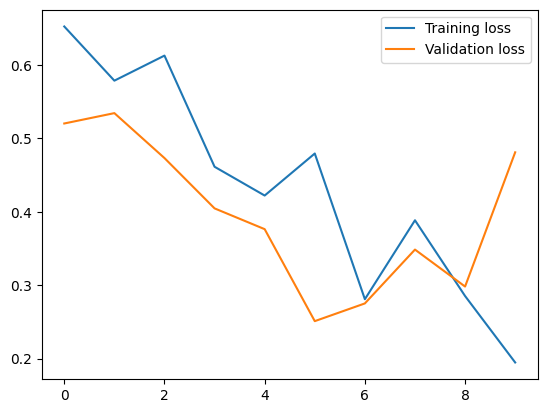

In [103]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [104]:
print(f"Accuracy : Train {accuracy(model, train_gen)} Valid {accuracy(model, valid_gen)} Test {accuracy(model, test_gen)}")

Accuracy : Train 0.94425 Valid 0.8554 Test 0.85552


* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).

In [88]:
def predict(model: nn.Module, text: str) -> int:
    """
    Predict the class of a single sample
    :param model: model to use for prediction
    :param text: text to predict
    :return: the predicted class and its confidence
    """
    X = torch.tensor(vectorize_text(text, vocabulary, tokenizer)).unsqueeze(0).to(device)

    # Compute the prediction.
    model.eval()
    y_pred = model(X)
    # Binary classification with Sigmoid.
    y_pred = torch.sigmoid(y_pred.squeeze())
    y_pred = torch.round(y_pred)

    return int(y_pred.item())

In [89]:
train_df["text"][0]

'After reading tons of good reviews about this movie I decided to take it for a spin (I bought it on DVD, hence the "spin" pun...I\'m a dork). The beginning was everything I hoped for, a perfect set-up (along with some quotes that I\'ve heard on Various Wu-Tang albums) to what should have been a good movie. But the plot I heard was so great, was so predictable. Every time I saw a character (except for the Lizard) I guessed which Venom he was. Plus, the only cool character gets killed off in the middle of the movie. Ok, so the plot wasn\'t very good but at least there was some good kung-fu right? Wrong. The fights were very short and few and far between. Granted the different styles were all pretty cool but I wish the fights were longer. I kept hoping to see the Lizard run and do some crazy ish on the walls but it never happened. I was hoping to see the Centipede do some tight speedy ish but it never happened. I was hoping to see the Scorpion in the movie for more than 7 total minutes b

In [90]:
predict(model, train_df["text"][0])

/tmp/ipykernel_1248/1727851234.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(vectorize_text(text, vocabulary, tokenizer)).unsqueeze(0).to(device)


0

* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.

In [91]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(vocab_size, embed_size)

        # The BiLSTM
        self.bilstm = nn.LSTM(
            input_size= embed_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
        )

        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(hidden_size * 2, n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        :param X: Input tensor of dimension batch_size, sequence length.
        :return: The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        out, _ = self.bilstm(out, (h0, c0))
        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [92]:
model_bilstm = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_bilstm.parameters())

In [93]:
best_model_bilstm, train_losses, valid_losses = train(model_bilstm, criterion, optimizer, 10, train_gen, valid_gen)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Training loss: 0.4840850830078125 | Validation loss: 0.5602753162384033
Epoch 2/10 | Training loss: 0.41293999552726746 | Validation loss: 0.5712141990661621
Epoch 3/10 | Training loss: 0.3095182180404663 | Validation loss: 0.521230936050415
Epoch 4/10 | Training loss: 0.2746129333972931 | Validation loss: 0.576640248298645
Epoch 5/10 | Training loss: 0.23709052801132202 | Validation loss: 0.567942202091217
Epoch 6/10 | Training loss: 0.29192352294921875 | Validation loss: 0.6285799145698547
Epoch 7/10 | Training loss: 0.20355595648288727 | Validation loss: 0.7134546637535095
Epoch 8/10 | Training loss: 0.1686156988143921 | Validation loss: 0.6079778075218201
Epoch 9/10 | Training loss: 0.13527148962020874 | Validation loss: 0.7882618308067322
Epoch 10/10 | Training loss: 0.12008540332317352 | Validation loss: 0.7170019149780273


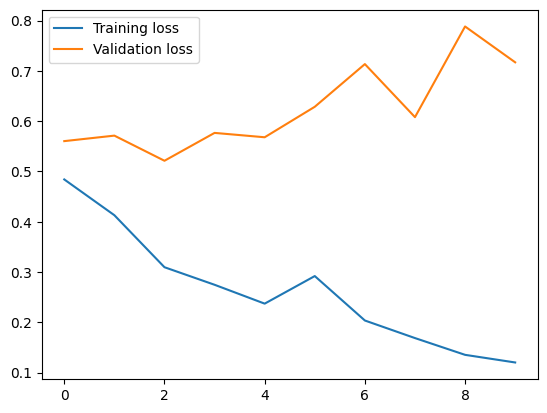

In [94]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [95]:
print(f"Accuracy : Train {accuracy(model_bilstm, train_gen)} Valid {accuracy(model_bilstm, valid_gen)} Test {accuracy(model_bilstm, test_gen)}")

Accuracy : Train 0.95395 Valid 0.8316 Test 0.83776


* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.

In [99]:
train_df["label"][0]

1

In [113]:
# 38
i = 15
while predict(model, train_df["text"][i]) == train_df["label"][i]:
    i += 1
print(i, train_df["text"][i], train_df["label"][i], predict(model, train_df["text"][i]))

/tmp/ipykernel_1248/1727851234.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(vectorize_text(text, vocabulary, tokenizer)).unsqueeze(0).to(device)


38 This movie has everything that makes a bad movie worth watching - sloppy editing, little to no continuity, insane dialog, bad (you might even say non-existent) acting, pointless story lines, shots that go on FAR too long...and it's perfect for MST3K-style riffing, not to mention the "Corpse Eaters Drinking Game": Scribble on forms...take a shot - Sign your name...take a shot - Catch a bad Foley edit...take many, many shots.<br /><br />The only reason I didn't rate it higher than 8 is because there's not enough gratuitous nudity and because despite its insane badness, it's only an hour long - hell, a movie like this should have been at least 20-30 minutes longer! 1 0


Example 1 : classified as 0 (negative) instead of 1 (positive) :

__*This movie has everything that makes a bad movie worth watching - sloppy editing, little to no continuity, insane dialog, bad (you might even say non-existent) acting, pointless story lines, shots that go on FAR too long...and it's perfect for MST3K-style riffing, not to mention the "Corpse Eaters Drinking Game": Scribble on forms...take a shot - Sign your name...take a shot - Catch a bad Foley edit...take many, many shots.<br /><br />The only reason I didn't rate it higher than 8 is because there's not enough gratuitous nudity and because despite its insane badness, it's only an hour long - hell, a movie like this should have been at least 20-30 minutes longer!*__

RNN aren't able to memorize data for long, the LSTM models try to fix this issue, by the addition of gates. We can assume that the gates worked well on this example and remembered the beginning of the sentence. At the beginning of the review, the reviewer clearly depicted the movie as bad, however near the end the reviewer added that he liked the movie for this reason, which is counterintuitive.

*NB : An RNN would have more chance to classify it correctly.*

In [117]:
i = 84
while predict(model, train_df["text"][i]) == train_df["label"][i]:
    i += 1
print(i, train_df["text"][i], train_df["label"][i], predict(model, train_df["text"][i]))

/tmp/ipykernel_1248/1727851234.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(vectorize_text(text, vocabulary, tokenizer)).unsqueeze(0).to(device)


90 I'm a Jean Harlow fan, because she had star quality. I don't think her movies are good and I don't even think that she was a good actress, but she certainly was Great in comedies. Every bit of comedy in The Girl from Missouri is very good. But this movie is perhaps more like a love story. Jean Harlow is wonderful in this one and you can forget the rest of the cast - their performances bring nothing new. It always impresses me much to think that Harlow's beautiful body was that of an ill woman. Well, in this movie she does look beautiful. 0 1


Example 2 : classified as __1 (positive)__ instead of __0 (negative)__:

*__I'm a Jean Harlow fan, because she had star quality. I don't think her movies are good and I don't even think that she was a good actress, but she certainly was Great in comedies. Every bit of comedy in The Girl from Missouri is very good. But this movie is perhaps more like a love story. Jean Harlow is wonderful in this one and you can forget the rest of the cast - their performances bring nothing new. It always impresses me much to think that Harlow's beautiful body was that of an ill woman. Well, in this movie she does look beautiful.__*

Just like before, this example demonstrates how the LSTM model is capable of memorizing the beginning and the end of the sentence, compared to an RNN which would likely just classify the example according to the end of it. In this case, with the entire sentence it is difficult to classify it correctly, an improvement would be to remove useless parts from reviews which don't add critical information to the review, such as : *__"Well, in this movie she does look beautiful."__*.

* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

We decided to use the package Optuna for hyperparameters search.

In [121]:
def objective(trial: optuna.Trial) -> float:
    """Function to optimize.
    Args:
        trial: an optuna trial.
    Returns:
        The validation loss.
    """
    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_embed = trial.suggest_int("n_embed", 32, 128)
    n_hidden = trial.suggest_int("n_hidden", 32, 128)
    
    model = LSTM(len(vocabulary), n_embed, n_hidden, n_layers, 1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    best_model, train_losses, valid_losses = train(model, criterion, optimizer, 5, train_gen, valid_gen)
    return accuracy(best_model, valid_gen)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2023-05-18 14:49:49,308] A new study created in memory with name: no-name-69752858-924c-4cc6-be5a-55cc4fa7bcc4


  0%|          | 0/5 [00:00<?, ?it/s]

[W 2023-05-18 14:50:36,547] Trial 0 failed with parameters: {'n_layers': 3, 'n_embed': 96, 'n_hidden': 56} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1248/316774637.py", line 15, in objective
    best_model, train_losses, valid_losses = train(model, criterion, optimizer, 5, train_gen, valid_gen)
  File "/tmp/ipykernel_1248/2401082919.py", line 33, in train
    loss.backward()
  File "/opt/conda/lib/python3.10/site-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2023-05-18 14:50:36,552] Trial 0 failed with value None.


KeyboardInterrupt: 